In [34]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap
import re
from math import sqrt, isnan

In [35]:
df_juegos_steam= pd.read_parquet('steam_games_listo.parquet')

df_user_reviews = pd.read_parquet('df_user_reviews_clean.parquet')

df_user_items = pd.read_parquet('df_user_items.parquet')


# EDA de Steam_games

In [36]:
df_juegos_steam.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32133 entries, 88310 to 120444
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            32133 non-null  object 
 1   publisher     32133 non-null  object 
 2   genres        32133 non-null  object 
 3   app_name      32133 non-null  object 
 4   price         32133 non-null  float64
 5   early_access  32133 non-null  float64
 6   developer     32133 non-null  object 
 7   anio          32133 non-null  object 
dtypes: float64(2), object(6)
memory usage: 2.2+ MB


In [37]:
# Obtener la frecuencia de valores únicos en la columna "price"
frecuencia_precios = df_juegos_steam['price'].value_counts()

# Crear un DataFrame con la frecuencia de precios
df_frecuencia_precios = pd.DataFrame(frecuencia_precios).reset_index()
df_frecuencia_precios.columns = ['Precio', 'Frecuencia']

# Imprimir el DataFrame de frecuencia de precios
print(df_frecuencia_precios)

# Obtener estadísticas resumidas para la columna "price"
estadisticas_precios = df_juegos_steam['price'].describe()

# Imprimir las estadísticas resumidas
print("\nEstadísticas resumidas para la columna 'price':")
print(estadisticas_precios)

     Precio  Frecuencia
0      4.99        4278
1      9.99        3902
2      2.99        3429
3      0.00        3286
4      0.99        2607
..      ...         ...
141   26.99           1
142  179.00           1
143   10.49           1
144    6.66           1
145  160.91           1

[146 rows x 2 columns]

Estadísticas resumidas para la columna 'price':
count    32133.000000
mean         8.500474
std         15.897191
min          0.000000
25%          1.990000
50%          4.990000
75%          9.990000
max        995.000000
Name: price, dtype: float64


In [38]:
# Calcular el rango intercuartílico (IQR)
Q1 = df_juegos_steam['price'].quantile(0.25)
Q3 = df_juegos_steam['price'].quantile(0.75)
IQR = Q3 - Q1

# Definir los límites para identificar outliers
lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

# Identificar outliers
outliers = df_juegos_steam[(df_juegos_steam['price'] < lower_limit) | (df_juegos_steam['price'] > upper_limit)]

# Mostrar la cantidad de outliers
print("Cantidad de Outliers:", len(outliers))


Cantidad de Outliers: 1874


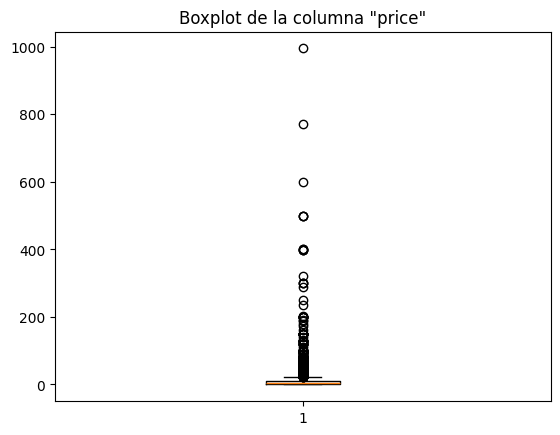

In [39]:
# Crear un gráfico de caja para visualizar outliers
plt.boxplot(df_juegos_steam['price'])
plt.title('Boxplot de la columna "price"')
plt.show()

Intenté utilizar SimpleImputer pero la verdad que no me daba ningún resultado notorio. Así que opte por algo más "manual"

In [40]:
# Eliminar outliers del DataFrame original
df_juegos_steam = df_juegos_steam[(df_juegos_steam['price'] >= lower_limit) & (df_juegos_steam['price'] <= upper_limit)]



In [41]:
# Obtener estadísticas resumidas para la columna "price"
estadisticas_precios = df_juegos_steam['price'].describe()

# Imprimir las estadísticas resumidas
print("\nEstadísticas resumidas para la columna 'price':")
print(estadisticas_precios)


Estadísticas resumidas para la columna 'price':
count    30259.000000
mean         6.210441
std          5.418607
min          0.000000
25%          1.990000
50%          4.990000
75%          9.990000
max         21.990000
Name: price, dtype: float64


**Transformaciones**


In [42]:
umbral_frecuencia = 1  # Puedes ajustar este umbral según sea necesario

# Filtrar valores con frecuencia menor o igual al umbral
df_frecuencia_filtrada = df_frecuencia_precios[df_frecuencia_precios['Frecuencia'] >= umbral_frecuencia].copy()

# Normalización min-max
min_price = df_frecuencia_filtrada['Precio'].min()
max_price = df_frecuencia_filtrada['Precio'].max()
df_frecuencia_filtrada['price'] = df_frecuencia_filtrada['Precio']
df_frecuencia_filtrada['price_norm'] = (df_frecuencia_filtrada['Precio'] - min_price) / (max_price - min_price)

# Agrupar por rangos de precios
bins = [0, 1, 5, 10, 20, 50, 100, 200, np.inf]  # Modificado para terminar en 100
labels = ['0-1', '1-5', '5-10', '10-20', '20-50', '50-100', '100-200', "200-500"]
df_frecuencia_filtrada['price_groupnorm'] = pd.cut(df_frecuencia_filtrada['Precio'], bins=bins, labels=labels, right=False)

# Verificar los resultados
print(df_frecuencia_filtrada[['price', 'Frecuencia', 'price_norm', 'price_groupnorm']])

      price  Frecuencia  price_norm price_groupnorm
0      4.99        4278    0.005015             1-5
1      9.99        3902    0.010040            5-10
2      2.99        3429    0.003005             1-5
3      0.00        3286    0.000000             0-1
4      0.99        2607    0.000995             0-1
..      ...         ...         ...             ...
141   26.99           1    0.027126           20-50
142  179.00           1    0.179899         100-200
143   10.49           1    0.010543           10-20
144    6.66           1    0.006693            5-10
145  160.91           1    0.161719         100-200

[146 rows x 4 columns]


Gráfico de precios por frecuencias

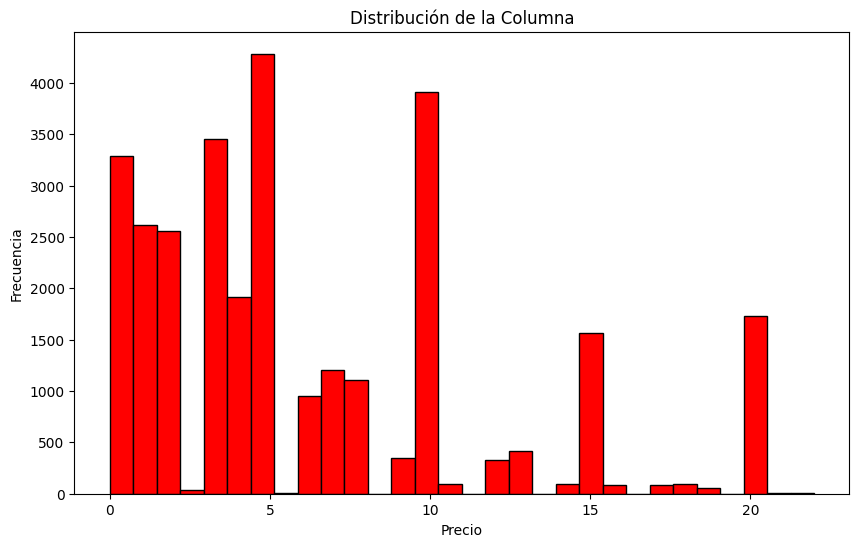

In [46]:
# Crear un gráfico de barras para visualizar la columna 'price'
plt.figure(figsize=(10, 6))
plt.hist(df_juegos_steam['price'], bins=30, color='red', edgecolor='black')

# Configurar el título y las etiquetas de los ejes
plt.title('Distribución de la Columna')
plt.xlabel('Precio')
plt.ylabel('Frecuencia')

# Mostrar el gráfico
plt.show()

Columna Juegos vamos ahora

In [27]:
# Contar valores únicos en la columna 'item_id'
total_juegos = df_juegos_steam['id'].nunique()

# Eliminar duplicados, valores perdidos y "Sin dato"
df_juegos_cleaned = df_juegos_steam['id'].str.lower().replace('sin dato', pd.NA).dropna().drop_duplicates()

# Contar valores perdidos y "Sin dato" después de la limpieza
valores_perdidos = df_juegos_steam['id'].isna().sum()
sin_dato_count = (df_juegos_steam['id'].str.lower() == 'sin dato').sum()

# Imprimir resultados
print(f"Total de juegos únicos: {total_juegos}")
print(f"Valores perdidos: {valores_perdidos}")
print(f"\"Sin dato\" count: {sin_dato_count}")


Total de juegos únicos: 30259
Valores perdidos: 0
"Sin dato" count: 0


C:\Users\User\AppData\Local\Temp\ipykernel_13396\2362371752.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x=conteo_generos_agrupado.values, y=conteo_generos_agrupado.index, palette="coolwarm", saturation=0.8)


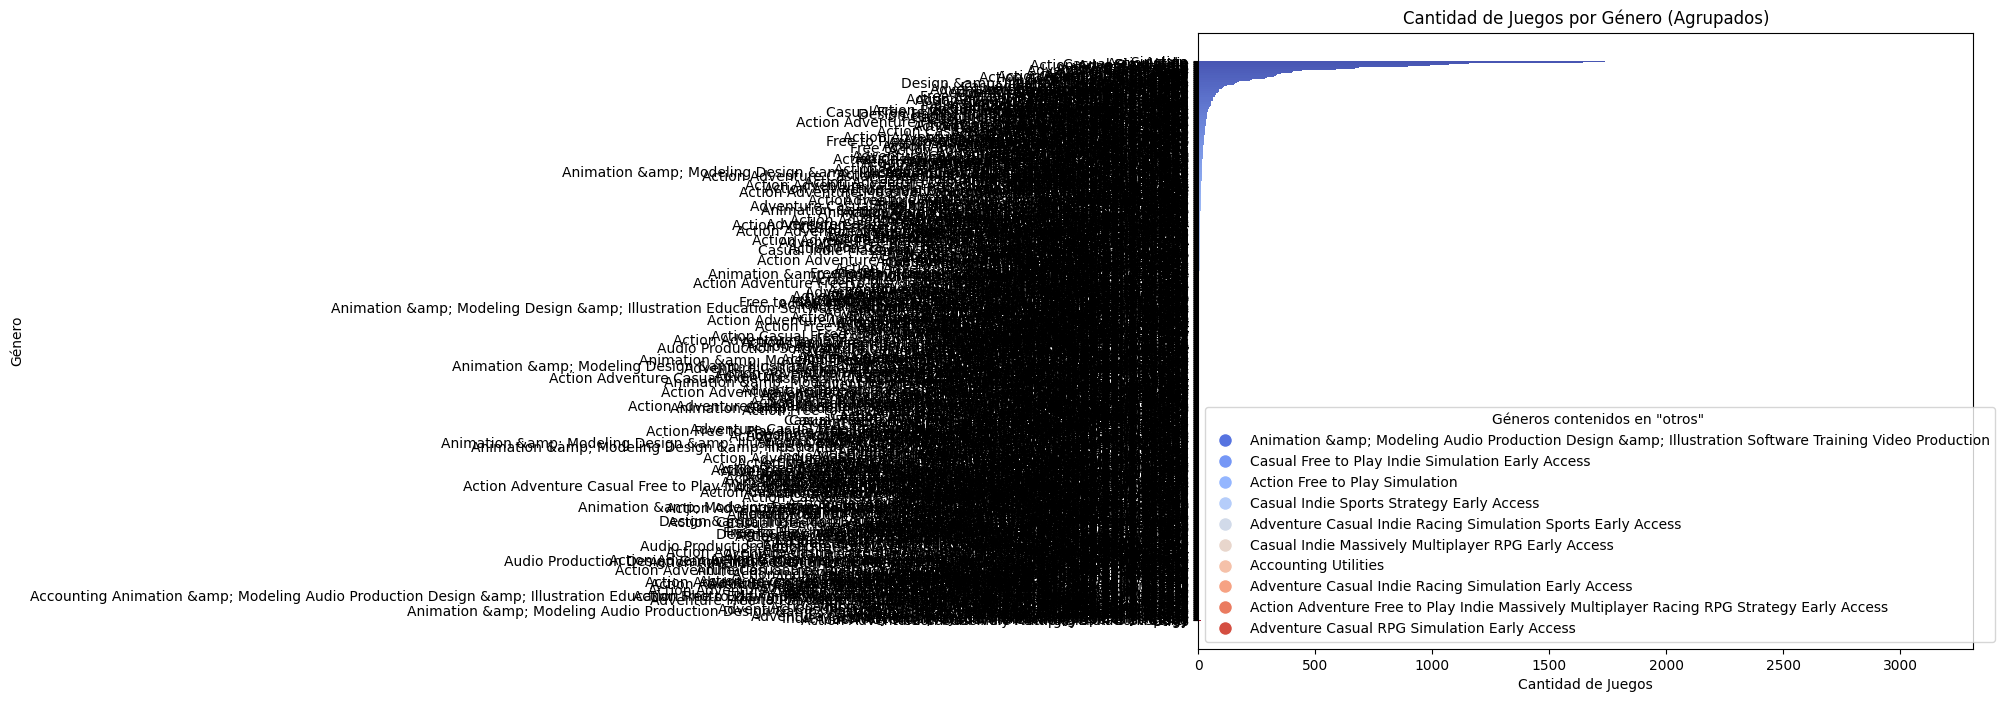

In [28]:
# Dividir la columna 'genres' que contiene varios géneros separados por comas
generos_separados = df_juegos_steam['genres'].str.split(',')

# Crear una lista plana de todos los géneros
todos_los_generos = [genero.strip() for sublist in generos_separados.dropna() for genero in sublist]

# Contar la frecuencia de cada género
conteo_generos = pd.Series(todos_los_generos).value_counts()

# Obtener los 10 géneros con menos cantidad
generos_menos_comunes = conteo_generos.tail(10).index

# Agrupar los 10 géneros menos comunes en una sola entrada llamada 'Otros'
conteo_generos_agrupado = conteo_generos.copy()
conteo_generos_agrupado['Otros'] = conteo_generos[generos_menos_comunes].sum()
conteo_generos_agrupado = conteo_generos_agrupado.drop(generos_menos_comunes)

# Obtener colores para 'Otros' en función de la cantidad de juegos en esos géneros
colores_otros = sns.color_palette("coolwarm", len(generos_menos_comunes))

# Crear un gráfico de barras horizontales con colores personalizados para cada género
plt.figure(figsize=(10, 8))
barplot = sns.barplot(x=conteo_generos_agrupado.values, y=conteo_generos_agrupado.index, palette="coolwarm", saturation=0.8)

# Añadir barras separadas para cada género dentro de 'Otros' con colores personalizados
for i, genero in enumerate(generos_menos_comunes):
    plt.barh('Otros', conteo_generos[genero], color=colores_otros[i])

# Configurar el título y las etiquetas de los ejes
plt.title('Cantidad de Juegos por Género (Agrupados)')
plt.xlabel('Cantidad de Juegos')
plt.ylabel('Género')

# Añadir una leyenda solo para 'Otros'
legend_labels = [(genero, colores_otros[i]) for i, genero in enumerate(generos_menos_comunes)]
barplot.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label) for label, color in legend_labels], title='Géneros contenidos en "otros" ')

# Mostrar el gráfico
plt.show()


No entiendo que pasa con los graficos. Estan bien pero siempre me quedan hiper apretados cuando no deberían ya que considero que el código está bien

In [29]:
# Dividir la columna 'genres' que contiene varios géneros separados por comas
generos_separados = df_juegos_steam['genres'].str.split(',')

# Crear una lista plana de todos los géneros
todos_los_generos = [genero.strip() for sublist in generos_separados.dropna() for genero in sublist]

# Contar la frecuencia de cada género
conteo_generos = pd.Series(todos_los_generos).value_counts()

# Calcular el porcentaje de juegos por género
porcentaje_generos = (conteo_generos / len(df_juegos_steam) * 100).round(2)

# Crear un DataFrame con los resultados
df_resultado = pd.DataFrame({
    'Cantidad de Juegos': conteo_generos,
    'Porcentaje': porcentaje_generos
})

# Agregar el signo de porcentaje al formato de la columna 'Porcentaje'
df_resultado['Porcentaje'] = df_resultado['Porcentaje'].astype(str) + '%'

# Imprimir el DataFrame resultante
df_resultado


,Cantidad de Juegos,Porcentaje
Sin dato,3154,10.42%
Action,1737,5.74%
Action Indie,1643,5.43%
Casual Simulation,1354,4.47%
Simulation,1158,3.83%
...,...,...
Casual Indie Massively Multiplayer RPG Early Access,1,0.0%
Accounting Utilities,1,0.0%
Adventure Casual Indie Racing Simulation Early Access,1,0.0%
Action Adventure Free to Play Indie Massively Multiplayer Racing RPG Strategy Early Access,1,0.0%


In [31]:
# Eliminar duplicados en item_Id
df_juegos_no_duplicados = df_juegos_steam.drop_duplicates(subset='id')

# Calcular la suma de ventas por año
ventas_por_anio = df_juegos_no_duplicados.groupby('anio')['price'].sum()

# Seleccionar los tres años con mayores ventas
top_tres_anios = ventas_por_anio.nlargest(3).index

# Filtrar el DataFrame original para incluir solo los juegos de los tres años seleccionados
df_top_tres_anios = df_juegos_no_duplicados[df_juegos_no_duplicados['anio'].isin(top_tres_anios)]

# Para cada año, mostrar el top 5 de juegos más caros
for anio in top_tres_anios:
    top_5_juegos_anio = df_top_tres_anios[df_top_tres_anios['anio'] == anio].nlargest(5, 'price')
    print(f'\nTop 5 juegos más caros en {anio}:\n')
    print(top_5_juegos_anio[['app_name', 'price']])



Top 5 juegos más caros en 2017:

                                                app_name  price
12988  STAR OCEAN™ - THE LAST HOPE -™ 4K & Full HD Re...  20.99
10946  Steel Division: Normandy 44 - Deluxe Edition U...  20.00
17036                                            ESSENCE  20.00
7935   Fantasy Grounds - The Last Parsec: Core (Savag...  19.99
8007                    Fishing Planet: Winter Pike Pack  19.99

Top 5 juegos más caros en 2016:

                                       app_name  price
5051            ARSLAN - Original Costume Set 1  20.99
22124                          FINAL FANTASY IX  20.99
9352   Black Desert Online - Traveler's Package  20.00
22701                                  Factorio  20.00
4764     FSX: Steam Edition - Extra 300S Add-On  19.99

Top 5 juegos más caros en 2015:

                                       app_name  price
4007            Trine 3: The Artifacts of Power  21.99
23913                   SW4-II - Edit Parts Set  21.99
23915            SW

Desarrolladora

C:\Users\User\AppData\Local\Temp\ipykernel_13396\3199114474.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=top_10_desarrolladores.values, y=top_10_desarrolladores.index, palette="viridis")


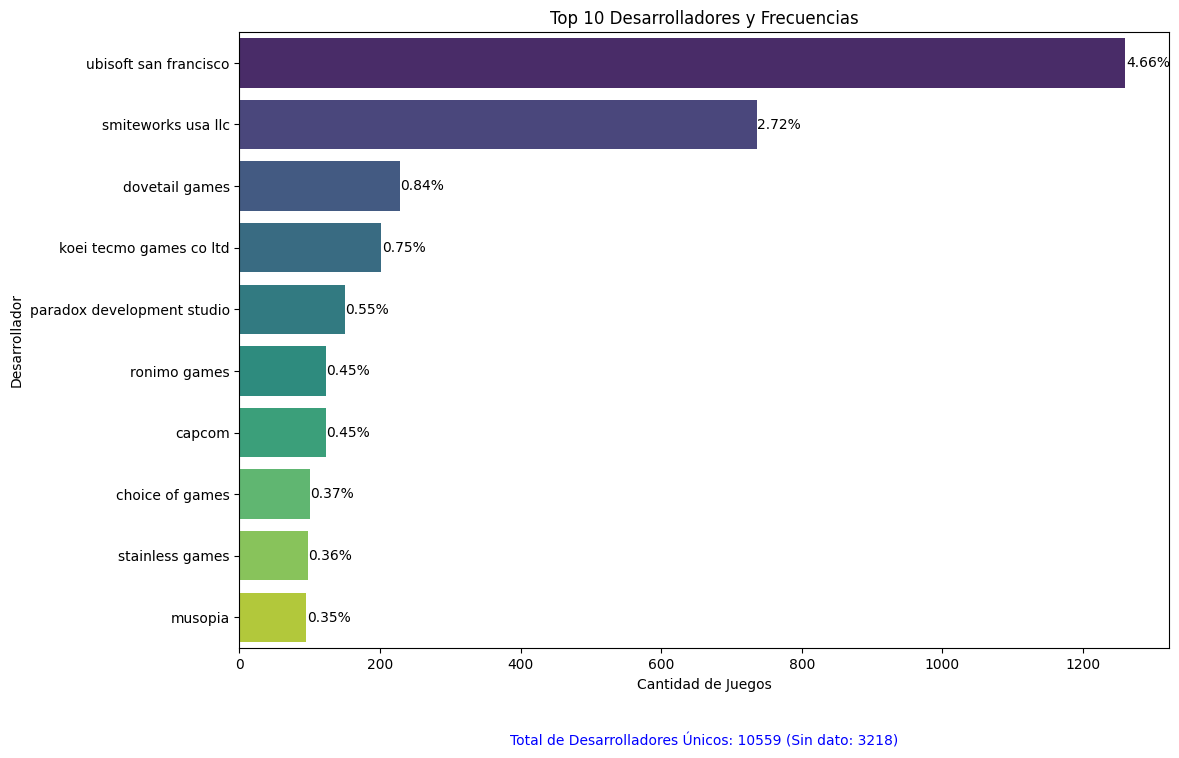

In [32]:
# Eliminar duplicados de item_id
df_juegos_sin_duplicados = df_juegos_steam.drop_duplicates(subset='id')

# Quitar los valores "Sin dato" (mayúsculas o minúsculas) de la columna 'developer'
df_juegos_sin_duplicados = df_juegos_sin_duplicados[df_juegos_sin_duplicados['developer'].str.lower() != 'sin dato']

# Contar la frecuencia de cada desarrollador
conteo_desarrolladores = df_juegos_sin_duplicados['developer'].value_counts()

# Obtener los top 10 desarrolladores
top_10_desarrolladores = conteo_desarrolladores.head(10)

# Calcular el total de desarrolladores únicos, incluyendo "Sin dato"
total_desarrolladores = len(df_juegos_sin_duplicados['developer'].unique())
total_sin_dato = len(df_juegos_steam[df_juegos_steam['developer'].str.lower() == 'sin dato'])

# Crear un gráfico de barras horizontales
plt.figure(figsize=(12, 8))
ax = sns.barplot(x=top_10_desarrolladores.values, y=top_10_desarrolladores.index, palette="viridis")

# Añadir texto con el total de desarrolladores en alguna parte del gráfico
ax.text(0.5, -0.15, f'Total de Desarrolladores Únicos: {total_desarrolladores} (Sin dato: {total_sin_dato})', ha='center', va='center', transform=ax.transAxes, color='blue')

# Añadir el porcentaje en cada barra
for i, v in enumerate(top_10_desarrolladores.values):
    porcentaje = (v / len(df_juegos_sin_duplicados['developer']) * 100).round(2)
    ax.text(v + 1, i, f'{porcentaje}%', va='center', color='black')

# Configurar el título y las etiquetas de los ejes
plt.title('Top 10 Desarrolladores y Frecuencias')
plt.xlabel('Cantidad de Juegos')
plt.ylabel('Desarrollador')

# Mostrar el gráfico
plt.show()


Año de lanzamiento

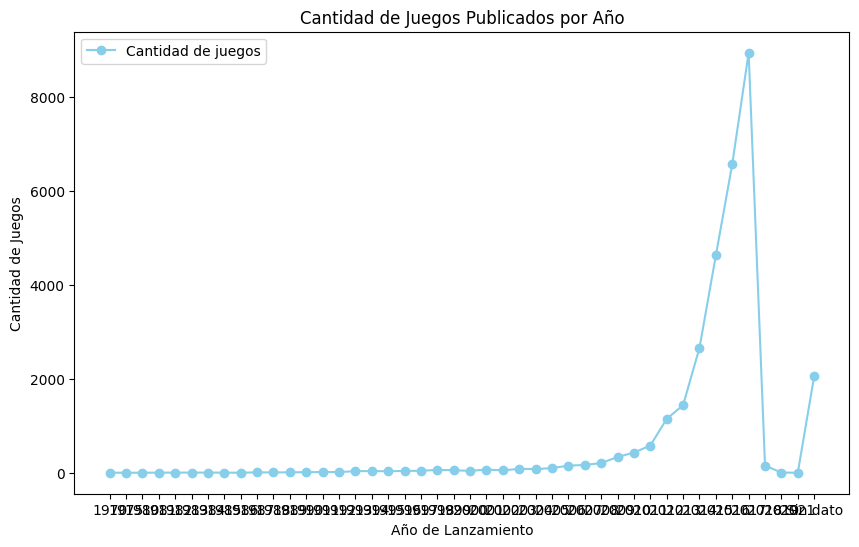

In [33]:
# Agrupar por año y contar la frecuencia
frecuencia_por_anio = df_juegos_steam['anio'].value_counts().sort_index()

# Crear un gráfico de línea
plt.figure(figsize=(10, 6))
plt.plot(frecuencia_por_anio.index, frecuencia_por_anio.values, marker='o', linestyle='-', color='skyblue', label='Cantidad de juegos')

# Configurar el título y las etiquetas de los ejes
plt.title('Cantidad de Juegos Publicados por Año')
plt.xlabel('Año de Lanzamiento')
plt.ylabel('Cantidad de Juegos')

# Mostrar la leyenda
plt.legend()

# Mostrar la gráfica
plt.show()


No entiendo que pasa con los graficos. Estan bien pero siempre me quedan hiper apretados cuando no deberían ya que considero que el código está bien

## EDA de df_user_items

In [38]:
df_user_items.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5094105 entries, 0 to 5153208
Data columns (total 5 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   user_id           object
 1   steam_id          object
 2   item_id           object
 3   item_name         object
 4   playtime_forever  int64 
dtypes: int64(1), object(4)
memory usage: 233.2+ MB


Vamos a obtener el tiempo de juego que es lo que nos interesa ahora

In [42]:
#Creamos un dataframe momentáneo
tiempo_juego = df_user_items.copy()
# Creamos un nuevo DataFrame con la suma de las horas totales por usuario
df_tiempo_total = tiempo_juego.groupby('user_id')['playtime_forever'].sum().reset_index()
# Hacemos un describe() para ver los cuartiles e información estadística básica
df_tiempo_total.describe()

,playtime_forever
count,7.091200e+04
mean,7.115821e+04
std,8.847746e+04
min,0.000000e+00
25%,1.149300e+04
50%,4.417300e+04
75%,1.010822e+05
max,4.660393e+06


El ScalarFormatter es una clase en matplotlib.ticker que se utiliza para controlar cómo se formatean las etiquetas de los ejes en los gráficos de Matplotlib. Aquí te explico algunos usos y beneficios clave de ScalarFormatter y de la configuración que estamos aplicando

In [44]:
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

Cantidad de horas dedicadas a los juegos

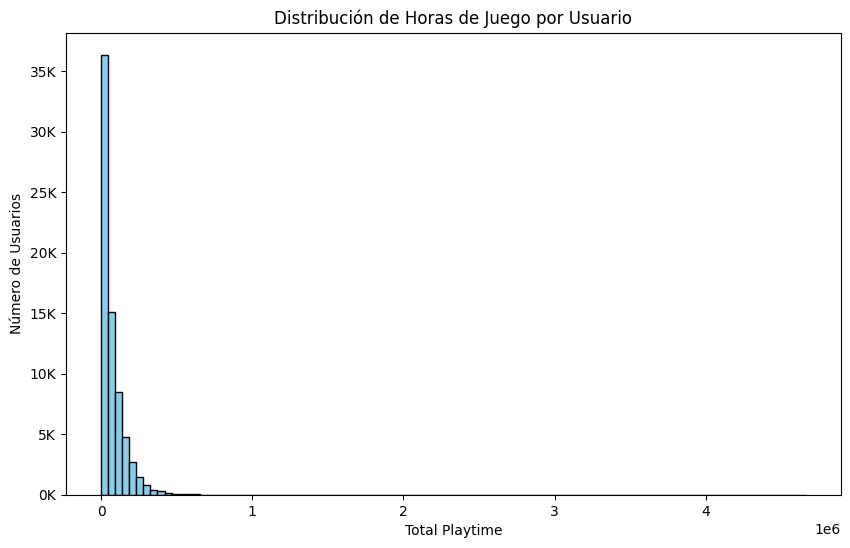

In [58]:
#Barras
barras = 100

# Graficar el histograma de las horas de juego por usuario
plt.figure(figsize=(10, 6))
plt.hist(df_tiempo_total['playtime_forever'], bins=barras, color='skyblue', edgecolor='black')

# Configurar el título y las etiquetas del eje
plt.title('Distribución de Horas de Juego por Usuario')
plt.xlabel('Total Playtime')
plt.ylabel('Número de Usuarios')

# Desactivar la notación científica en el eje y y dividir las etiquetas por 1000
plt.gca().yaxis.set_major_formatter(ScalarFormatter(useMathText=True, useOffset=False))
plt.gca().yaxis.set_major_formatter(lambda x, _: f'{int(x/1000)}K')

# Mostrar el gráfico
plt.show()

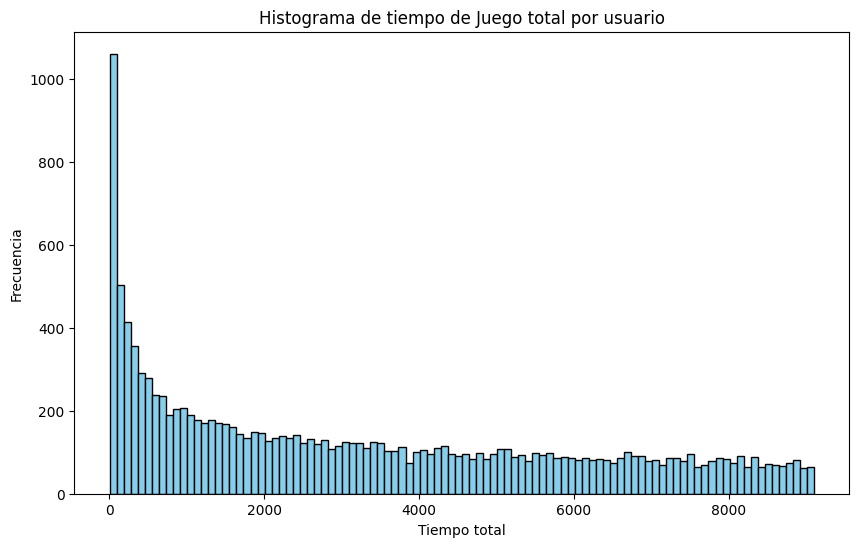

In [57]:
# Filtrar el DataFrame para excluir aquellos que juegan menos de 4 y más de 9100 unidades
df_filtro = df_tiempo_total[(df_tiempo_total['playtime_forever'] >= 4) & (df_tiempo_total['playtime_forever'] <= 9100)]

# Crear un histograma con los datos filtrados
plt.figure(figsize=(10, 6))
plt.hist(df_filtro['playtime_forever'], bins=100, color='skyblue', edgecolor='black')
plt.title('Histograma de tiempo de Juego total por usuario')
plt.xlabel('Tiempo total')
plt.ylabel('Frecuencia')
plt.show()


Juegos más jugado por la base de datos 

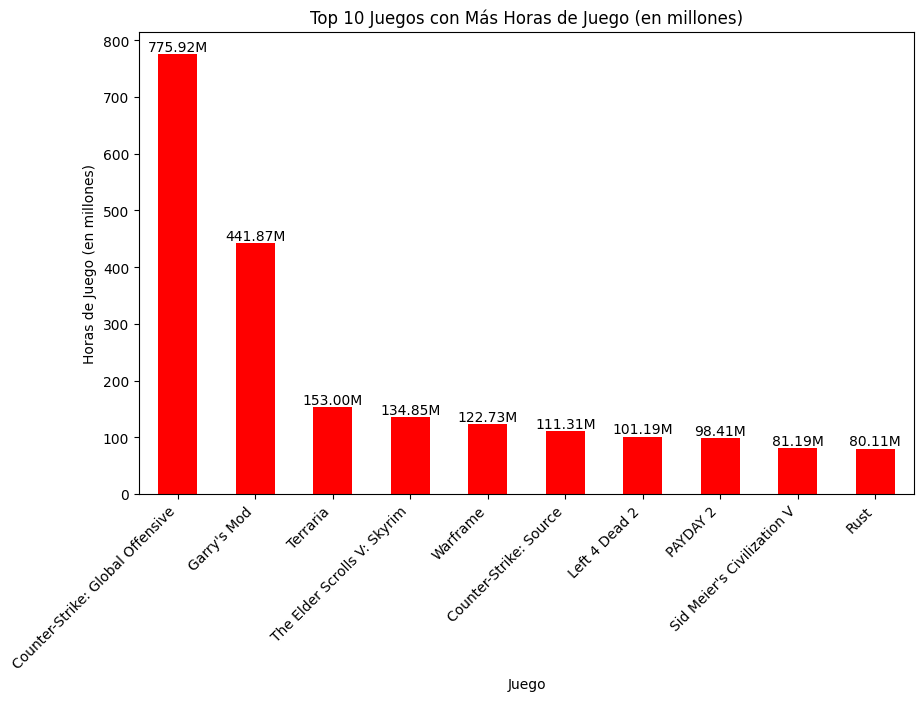

In [52]:
#Agrupasmos y hacemos la división por 1000000 ya que si no da un número gigante
horas_netas = df_user_items.groupby('item_name')['playtime_forever'].sum().nlargest(10) / 1000000 

# Graficar
plt.figure(figsize=(10, 6))
horas_netas.plot(kind='bar', color='red')
plt.title('Top 10 Juegos con Más Horas de Juego (en millones)')
plt.xlabel('Juego')
plt.ylabel('Horas de Juego (en millones)')
plt.xticks(rotation=45, ha='right')

# Agregar etiquetas de valor en las barras
for i, value in enumerate(horas_netas):
    plt.text(i, value + 0.1, f'{value:.2f}M', ha='center', va='bottom')

plt.show()

## EDA de df_user_review

In [53]:
df_user_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58400 entries, 0 to 25798
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   user_id          58400 non-null  object
 1   item_id          58400 non-null  object
 2   recommend        58400 non-null  bool  
 3   review           58400 non-null  object
 4   anio_lanzado     48471 non-null  Int64 
 5   Sentiment_Score  58400 non-null  int64 
dtypes: Int64(1), bool(1), int64(1), object(3)
memory usage: 2.8+ MB


Vemos la cantidad de reseñas que han dejado los jugadores a través de los años

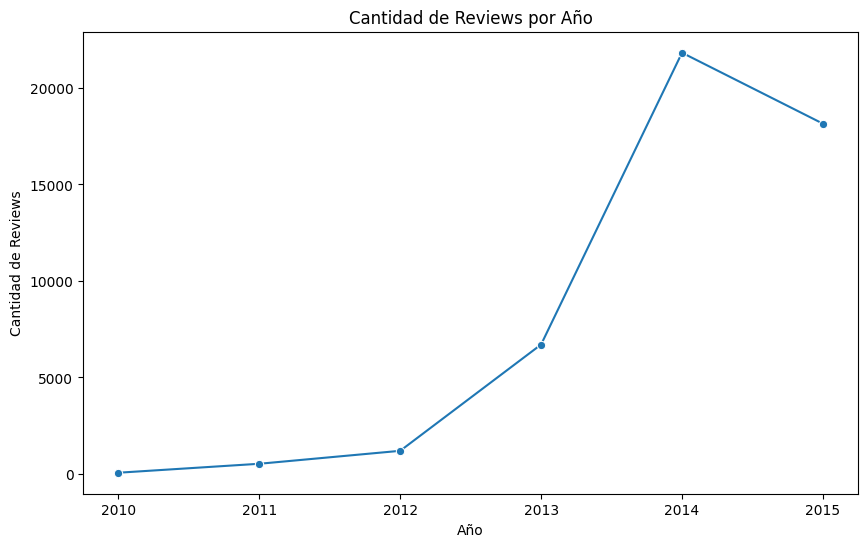

In [59]:
reviews_anuales = df_user_reviews['anio_lanzado'].value_counts().sort_index()

# Graficar la cantidad de reviews por año con línea de tendencia
plt.figure(figsize=(10, 6))
sns.lineplot(x=reviews_anuales.index, y=reviews_anuales.values, marker='o')

# Configurar el título y las etiquetas
plt.title('Cantidad de Reviews por Año')
plt.xlabel('Año')
plt.ylabel('Cantidad de Reviews')

# Mostrar el gráfico
plt.show()


Yo quería segmentar la columna ['Sentiment_category'] mediante esta línea de código 

df_users_review['Sentiment_Category'] = df_users_review['Sentiment_Category'].astype(object)
 pero iba a tener un problema grande a la hora de separar por valoraciones así que voy a proceder a realizar otra cosa

In [60]:
df_user_reviews['Sentiment_Category'] = pd.cut(df_user_reviews['Sentiment_Score'],
                                                                 bins=[-0.1, 0.9, 1.9, 2.1],
                                                                 labels=[0, 1, 2],
                                                                 include_lowest=True)

In [64]:

# Calcula la frecuencia de cada combinación de Sentiment_Category y recommend
frecuencia = pd.crosstab(index=[df_user_reviews['Sentiment_Category'], df_user_reviews['recommend']],
                        columns="Cantidad")

#Suma todas las valoraciones
suma = frecuencia.groupby('Sentiment_Category').sum()

frecuencia['Porcentaje'] = frecuencia.div(suma) * 100

frecuencia

C:\Users\User\AppData\Local\Temp\ipykernel_13396\1926615656.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  suma = frecuencia.groupby('Sentiment_Category').sum()


col_0                         Cantidad  Porcentaje
Sentiment_Category recommend                      
0                  False          2773   31.673330
                   True           5982   68.326670
1                  False          2818    9.533798
                   True          26740   90.466202
2                  False          1145    5.700204
                   True          18942   94.299796

In [8]:
seleccion = ['user_id','item_id','recommend','Sentiment_Score']

df_modelado = df_user_reviews[seleccion]

df_modelado

,user_id,item_id,recommend,Sentiment_Score
0,76561197970982479,1250,True,1
0,76561197970982479,22200,True,2
0,76561197970982479,43110,True,1
1,js41637,251610,True,1
1,js41637,227300,True,1
...,...,...,...,...
25797,76561198312638244,70,True,2
25797,76561198312638244,362890,True,1
25798,LydiaMorley,273110,True,1
25798,LydiaMorley,730,True,2


Construcción de escalas para los Sentiment_Score


In [9]:
# Definir la función para asignar valores según la escala
def escalas(fila):
    if fila['Sentiment_Score'] == 0 and fila['recommend'] == False:
        return 1
    elif fila['Sentiment_Score'] == 0 and fila['recommend'] == True:
        return 2
    elif fila['Sentiment_Score'] == 1 and fila['recommend'] == False:
        return 2
    elif fila['Sentiment_Score'] == 1 and fila['recommend'] == True:
        return 3
    elif fila['Sentiment_Score'] == 2 and fila['recommend'] == False:
        return 3
    elif fila['Sentiment_Score'] == 2 and fila['recommend'] == True:
        return 4

# Aplicar la función para crear la columna "eval" en df_user_model
df_modelado['eval'] = df_modelado.apply(escalas, axis=1)

# Imprimir el DataFrame resultante
df_modelado

C:\Users\User\AppData\Local\Temp\ipykernel_20416\4289112896.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_modelado['eval'] = df_modelado.apply(escalas, axis=1)


,user_id,item_id,recommend,Sentiment_Score,eval
0,76561197970982479,1250,True,1,3
0,76561197970982479,22200,True,2,4
0,76561197970982479,43110,True,1,3
1,js41637,251610,True,1,3
1,js41637,227300,True,1,3
...,...,...,...,...,...
25797,76561198312638244,70,True,2,4
25797,76561198312638244,362890,True,1,3
25798,LydiaMorley,273110,True,1,3
25798,LydiaMorley,730,True,2,4


Limpiamos antes la duda columnas

In [10]:
df_modelado.drop(['recommend','Sentiment_Score'],axis=1,inplace=True)



C:\Users\User\AppData\Local\Temp\ipykernel_20416\2861734930.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_modelado.drop(['recommend','Sentiment_Score'],axis=1,inplace=True)


In [11]:
df_nombre = df_user_items[['item_id', 'item_name']].copy()

In [12]:
#Se eliminan los duplicados
df_nombre = df_nombre.drop_duplicates(subset='item_id',keep='first')

df_nombre

,item_id,item_name
0,10,Counter-Strike
1,20,Team Fortress Classic
2,30,Day of Defeat
3,40,Deathmatch Classic
4,50,Half-Life: Opposing Force
...,...,...
4913278,375450,NOBUNAGA'S AMBITION: Souzou SengokuRisshiden
5092969,353390,Alienware Steam Machine
5105048,354280,ChaosTower
5119454,433920,Aveyond 4: Shadow Of The Mist


In [13]:
# Convertir la columna 'item_id' de ambos DataFrames a numérico
df_modelado['item_id'] = pd.to_numeric(df_modelado['item_id'], errors='coerce')
df_nombre['item_id'] = pd.to_numeric(df_nombre['item_id'], errors='coerce')

# Fusionar df_user_model con df_names usando la columna 'item_id'
df_user_model = pd.merge(df_modelado, df_nombre, on='item_id', how='left')

# Imprimir el DataFrame resultante
df_user_model

C:\Users\User\AppData\Local\Temp\ipykernel_20416\1271245183.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_modelado['item_id'] = pd.to_numeric(df_modelado['item_id'], errors='coerce')


,user_id,item_id,eval,item_name
0,76561197970982479,1250,3,Killing Floor
1,76561197970982479,22200,4,Zeno Clash
2,76561197970982479,43110,3,Metro 2033
3,js41637,251610,3,Barbie™ Dreamhouse Party™
4,js41637,227300,3,Euro Truck Simulator 2
...,...,...,...,...
58395,76561198312638244,70,4,Half-Life
58396,76561198312638244,362890,3,Black Mesa
58397,LydiaMorley,273110,3,Counter-Strike Nexon: Zombies
58398,LydiaMorley,730,4,Counter-Strike: Global Offensive


In [14]:
#Hacemos un inner join (merge)

df_modelado['item_id']= pd.to_numeric(df_modelado['item_id'],errors='coerce')

df_nombre['item_id'] = pd.to_numeric(df_nombre['item_id'],errors='coerce')

df_modelado = pd.merge(df_modelado,df_nombre,on='item_id',how='left')

df_modelado


C:\Users\User\AppData\Local\Temp\ipykernel_20416\1688698611.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_modelado['item_id']= pd.to_numeric(df_modelado['item_id'],errors='coerce')


,user_id,item_id,eval,item_name
0,76561197970982479,1250,3,Killing Floor
1,76561197970982479,22200,4,Zeno Clash
2,76561197970982479,43110,3,Metro 2033
3,js41637,251610,3,Barbie™ Dreamhouse Party™
4,js41637,227300,3,Euro Truck Simulator 2
...,...,...,...,...
58395,76561198312638244,70,4,Half-Life
58396,76561198312638244,362890,3,Black Mesa
58397,LydiaMorley,273110,3,Counter-Strike Nexon: Zombies
58398,LydiaMorley,730,4,Counter-Strike: Global Offensive


In [16]:
# Ver nulos

nulos = df_modelado.isnull().sum()

#print(nulos)

#Voy a eliminas las filas que tengan nulos

df_modelado.dropna(subset=['item_name'],inplace=True)

df_modelado

,user_id,item_id,eval,item_name
0,76561197970982479,1250,3,Killing Floor
1,76561197970982479,22200,4,Zeno Clash
2,76561197970982479,43110,3,Metro 2033
3,js41637,251610,3,Barbie™ Dreamhouse Party™
4,js41637,227300,3,Euro Truck Simulator 2
...,...,...,...,...
58394,76561198312638244,130,3,Half-Life: Blue Shift
58395,76561198312638244,70,4,Half-Life
58396,76561198312638244,362890,3,Black Mesa
58397,LydiaMorley,273110,3,Counter-Strike Nexon: Zombies


In [17]:
#Eliminamos 'item_id' de df_modelado

df_modelado.drop('item_id',axis=1,inplace=True)

df_modelado

,user_id,eval,item_name
0,76561197970982479,3,Killing Floor
1,76561197970982479,4,Zeno Clash
2,76561197970982479,3,Metro 2033
3,js41637,3,Barbie™ Dreamhouse Party™
4,js41637,3,Euro Truck Simulator 2
...,...,...,...
58394,76561198312638244,3,Half-Life: Blue Shift
58395,76561198312638244,4,Half-Life
58396,76561198312638244,3,Black Mesa
58397,LydiaMorley,3,Counter-Strike Nexon: Zombies


Graficamos los puntajes

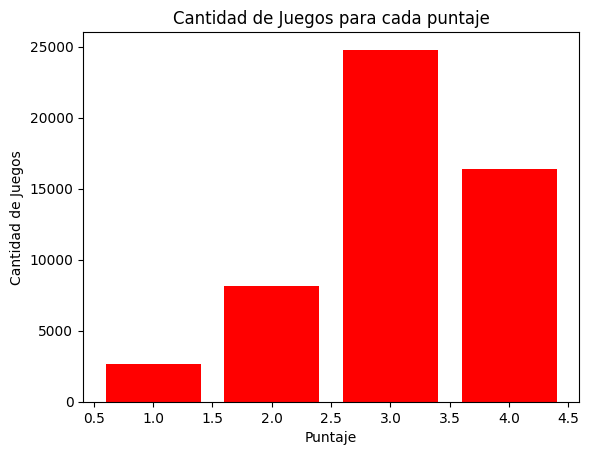

In [18]:
puntaje = df_modelado['eval'].value_counts()

# Crear un gráfico de barras
plt.bar(puntaje.index, puntaje.values, color='red')

# Añadir etiquetas y título
plt.xlabel('Puntaje')
plt.ylabel('Cantidad de Juegos')
plt.title('Cantidad de Juegos para cada puntaje')

# Mostrar el gráfico
plt.show()

Vamos a exportar el df_modelado por las dudas que nos puede llegar a servir a la hora de modelar

Importamos como siempre la librería de pyarrow para poder utilizar la exportación y posterior lectura

In [19]:
import pyarrow as pa

In [21]:
df_modelado = df_modelado.to_parquet('df_modelado.parquet', engine='pyarrow')